In [58]:
import pysabr
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [9]:
# data ranges to generate training data

# S_min = 0.005
# S_max = 0.07
# S_Ks = np.linspace(S_min/S_max, S_max/S_max, num=10)
# Ts = np.linspace(0.5, 20., num=10)
# ds = np.linspace(0.0, 0.03, num=5)

# V_atms = np.linspace(0.001, 0.02, num=3) # lognormal: 0.001 - 0.02, normal: .1 1.5
# betas = np.linspace(0.1, 0.7, num=3)
# rhos = np.linspace(-0.4, 0.4, num=3)
# volvols = np.linspace(0.0001, 0.5, num=3)


In [10]:
# test_sabr = pysabr.Hagan2002LognormalSABR(0.03, 0.0001, 1., 0.5, 0.9999, 0.0001, 0.0001)
# print(test_sabr.lognormal_vol(0.03)) # normal_vol / F ~ atm log normal vol

In [16]:
def data_gen_sabr(ranges, mode): # mode: ln or n
    print(f'mode: {mode}')
    start = time.time()
    Ss = ranges['Ss']
    Ts = ranges['Ts']
    V_atms = ranges['V_atms']
    betas = ranges['betas']
    rhos = ranges['rhos']
    volvols = ranges['volvols']
    ds = ranges['ds']
    Ks = ranges['Ks']

    sabr_processes = [pysabr.Hagan2002LognormalSABR(S, d, T, V_atm, beta, rho, volvol) if mode=='ln' \
                      else pysabr.Hagan2002NormalSABR(S, d, T, V_atm, beta, rho, volvol) \
                      for S in Ss \
                      for T in Ts \
                      for V_atm in V_atms \
                      for beta in betas \
                      for rho in rhos \
                      for volvol in volvols \
                      for d in ds
                     ]

    vols = np.reshape([sabr.lognormal_vol(k) if mode=='ln' else sabr.normal_vol(k) \
                       for sabr in sabr_processes \
                       for k in Ks], \
                       (Ss.shape[0], Ts.shape[0], V_atms.shape[0], betas.shape[0], rhos.shape[0], \
                        volvols.shape[0], ds.shape[0], Ks.shape[0])\
                     )

    end = time.time()
    print(f'compute vols time: {end - start}')
    names = ["S", "T", "V_atm", "Beta", "Rho", "Volvol", "Displacement", "K"]
    multiindex = pd.MultiIndex.from_product([range(i) for i in vols.shape],
                                            names=names
                                           )
    full_df = pd.DataFrame(vols.reshape((-1,1)), index=multiindex, columns=[f"{mode}_vol"])

    print(full_df.describe())
    print(full_df.loc[(full_df<0).values])
    return vols

In [47]:
# testing ranges:
# S_min = 0.005
# S_max = 0.07
# S_Ks = np.linspace(S_min/S_max, S_max/S_max, num=20)

Ss = np.array([0.005])
Ks = np.linspace(0.005, 0.07, num=20)
Ts = np.linspace(0.5, 20., num=20)

betas = np.array([0.1, 0.7])
rhos = np.array([-0.4])
volvols = np.array([0.5])
ds = np.array([0.01])

In [48]:
# lognormal:
V_atm_ln = np.array([0.01])

ln_ranges = {'Ss': Ss,
             'Ts': Ts,
             'V_atms': V_atm_ln,
             'betas': betas,
             'rhos': rhos,
             'volvols': volvols,
             'ds': ds,
             'Ks': Ks,
            }
    
ln_res = data_gen_sabr(ln_ranges, 'ln')
print(ln_res.shape)

mode: ln
compute vols time: 4.020172119140625
           ln_vol
count  800.000000
mean     0.690123
std      0.521946
min     -1.118567
25%      0.462085
50%      0.609450
75%      0.823596
max      2.981773
                                              ln_vol
S T  V_atm Beta Rho Volvol Displacement K           
0 16 0     1    0   0      0            15 -0.027068
                                        16 -0.069080
                                        17 -0.106742
                                        18 -0.140628
                                        19 -0.171218
  17 0     1    0   0      0            10 -0.003493
                                        11 -0.086844
                                        12 -0.159507
                                        13 -0.223265
                                        14 -0.279531
                                        15 -0.329436
                                        16 -0.373898
                                        17 -0.4136

In [50]:
# normal:
V_atm_n = np.array([0.01])

n_ranges = {'Ss': Ss,
             'Ts': Ts,
             'V_atms': V_atm_n,
             'betas': betas,
             'rhos': rhos,
             'volvols': volvols,
             'ds': ds,             
             'Ks': Ks,
            }
    
n_res = data_gen_sabr(n_ranges, 'n')
print(n_res.shape)

mode: n
compute vols time: 0.054962158203125
            n_vol
count  800.000000
mean     0.003091
std      0.016233
min     -0.038814
25%     -0.005582
50%      0.010192
75%      0.013713
max      0.023141
                                               n_vol
S T  V_atm Beta Rho Volvol Displacement K           
0 6  0     1    0   0      0            3  -0.000155
                                        4  -0.003063
                                        5  -0.005826
                                        6  -0.008473
                                        7  -0.011024
...                                              ...
  19 0     1    0   0      0            15 -0.030051
                                        16 -0.032270
                                        17 -0.034469
                                        18 -0.036650
                                        19 -0.038814

[228 rows x 1 columns]
(1, 20, 1, 2, 1, 1, 1, 20)


In [74]:
print(n_res.squeeze().shape)

(20, 2, 20)


In [97]:
def plot_vols(vols, ranges): # after squeeze, only betas remain
    fig = plt.figure(figsize=(15,15))
    X, Y = np.meshgrid(n_ranges['Ts'], n_ranges['Ks'])
    for beta_i in range(ranges['betas'].shape[0]):
        surface = vols[:, beta_i, :]
        ax = fig.add_subplot(1, ranges['betas'].shape[0], beta_i+1, projection='3d')
        surf = ax.plot_surface(X, Y, Z=surface, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0,
                                antialiased=False)
        ax.set_zlim(np.min(surface)*1.1, np.max(surface)*1.1)
        fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.show()
        
        
        
#      for s_i in range(ranges['Ss'].shape[0]):
#         for sigma_i in range(ranges['V_atms'].shape[0]):
            
#                 for rho_i in range(ranges['rhos'].shape[0]):
#                     for vv_i in range(ranges['volvols'].shape[0]):
#                         for d_i in range(ranges['ds'].shape[0]):
                            


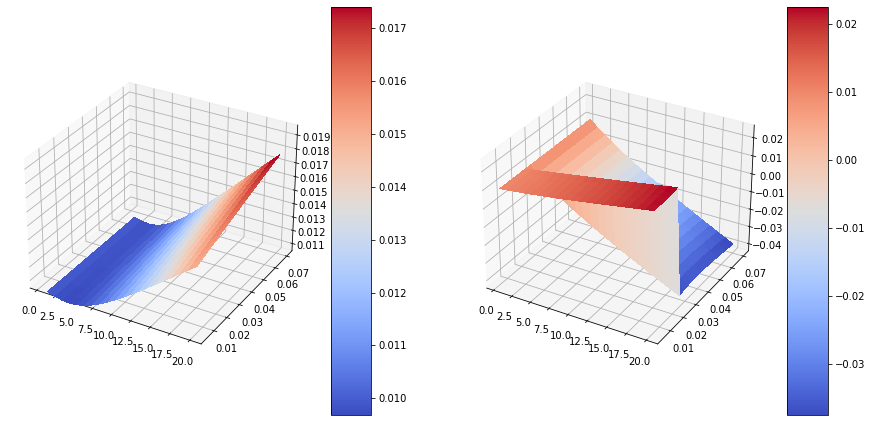

In [98]:
plot_vols(n_res.squeeze(), n_ranges)

In [ ]:
# pysabr.Hagan2002LognormalSABR(0.005, 0, 1, 0.1, 0.0001, -0.4, 0.0001).lognormal_vol(0.07)

In [ ]:
# data_path = "data/"
# np.save(data_path + "debug_sample_lognormal_vol.npy", vols)